# Show and Tell: A Neural Image Caption Generator

A neural network to generate captions for an image using CNN and RNN

![Examples](https://i.postimg.cc/bwb4J60Q/black-and-white-dog-is-running-through-grassy-field.png)



### Mounting google drive into notebook

Note: To get the complete dataset used in this dataset, make a copy of the drive link provided below in your own drive and then run this cell to get proper execution.

Dataset Folder Link: https://drive.google.com/drive/folders/1VOUAUphQN7jKPkS0fVPcRHhwHWBzbvk3?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


### Importing all required libraries:



*   Python - 3.6.7
*   Numpy
*   Tensorflow
*   Keras
*   Natural Language Toolkit (NLTK)
*   Pandas
*   Matplotlib
*   glob
*   Python Imaging Library (PIL)



In [2]:
try:
    import dill as pickle
except ImportError:
    import pickle

In [3]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


### Exploring Dataset and getting a basic idea:

In [4]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/gdrive/My Drive/Automatic-Image-Captioning-master/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


### Loading Descriptions and checking for some data:

In [5]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [6]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [7]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [8]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

### Cleaning Descriptions of Images:

Converting all letters to lower case and removing unnecessary puctuations and letters

In [9]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [10]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [11]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

### Converting Loaded descriptions into a vocabulary of words:

Building a list of all description strings

In [12]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


Saving all descriptions in a text file (one  per line)

In [13]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, '/gdrive/My Drive/Automatic-Image-Captioning-master/descriptions.txt')

### Load a pre-defined list of photo-identifiers:

In [14]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '/gdrive/My Drive/Automatic-Image-Captioning-master/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


### Extracting all images from the dataset:

Create a list of all names in the directory

In [15]:
# Below path contains all the images
images = '/gdrive/My Drive/Automatic-Image-Captioning-master/Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

### Splitting Data into train, test and validation sets:


*   train set - 6000 images
*   validation set - 1000 images
*   test set - 1000 images



Extracting train images and storing them in a list

In [16]:
# Below file conatains the names of images to be used in train data
train_images_file = '/gdrive/My Drive/Automatic-Image-Captioning-master/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

Extracting test images and storing them in a list

In [17]:
# Below file conatains the names of images to be used in test data
test_images_file = '/gdrive/My Drive/Automatic-Image-Captioning-master/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

Extracting validation images and storing them in a list

In [18]:
# Below file conatains the names of images to be used in validation data
dev_images_file = '/gdrive/My Drive/Automatic-Image-Captioning-master/Flickr_8k.devImages.txt'
# Read the validation image names in a set# Read the test image names in a set
dev_images = set(open(dev_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
dev_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in dev_images: # Check if the image belongs to test set
        dev_img.append(i) # Add it to the list of test images

### Loading Clean Descriptions into memory:

In [19]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('/gdrive/My Drive/Automatic-Image-Captioning-master/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


### Preprocessing Images:
Convert all images to size 299*299 as expected by Inception v3 model.
Preprocessing using preprocess_input() command.

In [20]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

#### Loading the inception v3 model:

*   Pre-trained model on many images.
*   Optionally loads weights pre-trained on ImageNet.



In [21]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

96116736/96112376 [==============================] - 8s 0us/step


### Creating Model:

Create a new model, by removing last layer from Inception v3 as it contains all the features of the image that we need.

In [22]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

Encoding all images into a vector of size (2048, )

In [23]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

Encoding all train images and saving the bottleneck features to disk

In [24]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 3580.2306365966797


In [25]:
# Save the bottleneck train features to disk
with open("/gdrive/My Drive/Automatic-Image-Captioning-master/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

Encoding all test images and saving the bottleneck features to disk

In [26]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 614.863508939743


In [27]:
# Save the bottleneck test features to disk
with open("/gdrive/My Drive/Automatic-Image-Captioning-master/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

Encoding all validation images and saving the bottleneck features to disk

In [28]:
# Call the funtion to encode all the validation images - Execute this only once
start = time()
encoding_dev = {}
for img in dev_img:
    encoding_dev[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 599.7518529891968


In [29]:
# Save the bottleneck test features to disk
with open("/gdrive/My Drive/Automatic-Image-Captioning-master/Pickle/encoded_dev_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_dev, encoded_pickle)

Loading all train features:

In [30]:
train_features = load(open("/gdrive/My Drive/Automatic-Image-Captioning-master/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


### Training Captions:
Creating a list of all training captions

In [31]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

Considering only those words which occur at least 10 times in the corpus

In [32]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


Coverting all words to indexes and indexes to word

In [33]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [34]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

Convert a dictionary to a list of descriptions

In [35]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


### Defining data generator function

In [36]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

### Loading Glove Vectors (200 D):

In [37]:
# Load Glove vectors
glove_dir = '/gdrive/My Drive/Automatic-Image-Captioning-master/glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, '/gdrive/My Drive/Automatic-Image-Captioning-master/glove/glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [38]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [39]:
embedding_matrix.shape

(1652, 200)

### Defining our LSTM model by setting different Hyper-parameters

In [88]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.2)(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(512)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Model Summary:

In [89]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 34, 200)      330400      input_9[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_8[0][0]                    
____________________________________________________________________________________________

In [90]:
model.layers[2]

In [91]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

Using Adam optimizer and categorical crossentropy as loss function:

In [92]:
lr = 0.0005
adam = Adam(lr)
model.compile(loss='categorical_crossentropy', optimizer='adam')

Setting-up no. of epochs, batch size and steps per epoch:

In [93]:
epochs = 12
number_pics_per_bath = 30
steps = len(train_descriptions)//number_pics_per_bath

Loading validation set features and descriptions:

In [94]:
dev_features = load(open("/gdrive/My Drive/Automatic-Image-Captioning-master/Pickle/encoded_dev_images.pkl", "rb"))
filename_dev = '/gdrive/My Drive/Automatic-Image-Captioning-master/Flickr_8k.devImages.txt'
dev = load_set(filename_dev)
dev_descriptions = load_clean_descriptions('/gdrive/My Drive/Automatic-Image-Captioning-master/descriptions.txt', dev)
validation_generator = data_generator(dev_descriptions, dev_features, wordtoix, max_length, number_pics_per_bath)

### Training model on specified no.of epochs on train set and validation set:

In [95]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
history = model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1, validation_data = validation_generator, validation_steps=steps)
model.save('/gdrive/My Drive/Automatic-Image-Captioning-master/model_weights/model_' + str(i) + '.h5')

Epoch 1/12
200/200 [==============================] - 119s 597ms/step - loss: 4.5525 - val_loss: 3.7577
Epoch 2/12
200/200 [==============================] - 117s 586ms/step - loss: 3.6039 - val_loss: 3.4448
Epoch 3/12
200/200 [==============================] - 117s 584ms/step - loss: 3.2860 - val_loss: 3.3188
Epoch 4/12
200/200 [==============================] - 117s 585ms/step - loss: 3.1001 - val_loss: 3.2599
Epoch 5/12
200/200 [==============================] - 117s 585ms/step - loss: 2.9618 - val_loss: 3.2244
Epoch 6/12
200/200 [==============================] - 117s 583ms/step - loss: 2.8457 - val_loss: 3.2213
Epoch 7/12
200/200 [==============================] - 117s 587ms/step - loss: 2.7473 - val_loss: 3.2241
Epoch 8/12
200/200 [==============================] - 117s 587ms/step - loss: 2.6617 - val_loss: 3.2645
Epoch 9/12
200/200 [==============================] - 117s 583ms/step - loss: 2.5846 - val_loss: 3.2566
Epoch 10/12
200/200 [==============================] - 117s 585m

### Loss plot of the model:

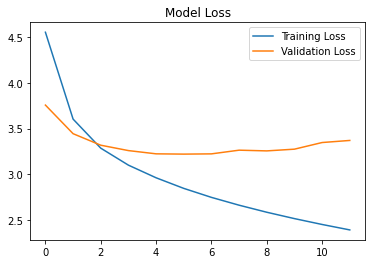

In [96]:
loss= history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

In [97]:
model.save_weights('/gdrive/My Drive/Automatic-Image-Captioning-master/model_weights/model_30.h5')

### Testing our model with test data:

Loading all images

In [98]:
images = '/gdrive/My Drive/Automatic-Image-Captioning-master/Flicker8k_Dataset/'

Encoding all images into required vectors

In [99]:
with open("/gdrive/My Drive/Automatic-Image-Captioning-master/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

### Defining Greedy Search and Beam Search for generating captions:

In [100]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [101]:
def beam_search_pred(photo, K_beams = 10, log = False):
    start_token = 'startseq'
    end_token = 'endseq'
    start = [wordtoix[start_token]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_length).reshape((1,max_length)) #sequence of most probable words
                                                                                          # based on the previous steps
            preds = model.predict([photo,sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:] # sort predictions based on the probability, then take the last
                                                          # K_beams items. words with the most probs
            # Getting the top <K_beams>(n) predictions and creating a
            # new list so as to put them via the model again
            for w in word_preds:
                
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words4
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])

        # Getting the top words
        start_word = start_word[-K_beams:]
    
    start_word = start_word[-1][0]
    captions_ = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in captions_:
        if i != end_token:
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

### Testing our model by using Greedy and Beam Search:

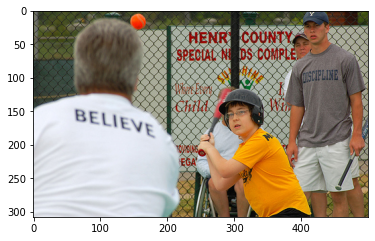

Greedy: boy in white shirt and white shorts is standing on the field
BLEU Score: 0.3073038432998781


In [115]:
import random
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

z=random.randint(0, 999)

pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

smoothie = SmoothingFunction().method7
output = []
references = descriptions[pic.replace('.jpg','')]
references = [c.split() for c in references]
output.append(greedySearch(image))
output = [i for item in output for i in item.split()]
score = bleu(references, output, smoothing_function=smoothie)
print("BLEU Score:", score)

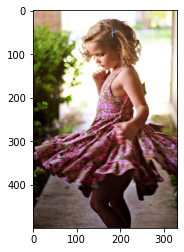

Beam: little girl in pink dress is walking down the street
BLEU Score: 0.5153543965927526


In [116]:
z=random.randint(0, 999)

pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
beam = beam_search_pred(image)
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Beam:",beam)

smoothie = SmoothingFunction().method7
output = []
references = descriptions[pic.replace('.jpg','')]
references = [c.split() for c in references]
output.append(beam)
output = [i for item in output for i in item.split()]
score = bleu(references, output, smoothing_function=smoothie)
print("BLEU Score:", score)

### Calculating average BLEU-4 scores:

In [107]:
# BLEU Score
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method7
references = []
output = []
result = []
for i in range (0, len(list(encoding_test.keys()))):
  s = list(encoding_test.keys())[i]
  
  references = descriptions[s.replace('.jpg','')]
  references = [c.split() for c in references]

  greedy = greedySearch(image)
  output.append(greedy)
  output = [i for item in output for i in item.split()]

  score = bleu(references, output, smoothing_function=smoothie)
  result.append(score)

print(result)
print("Average BLEU Score:", sum(result)/len(result))

[0.24378433052499146, 0.31172351910083307, 0.318058654875697, 0.3294380222814673, 0.327023469499603, 0.3303393419519124, 0.26901191435806093, 0.33559210231643416, 0.34067776576593045, 0.34229673841951264, 0.24700626024601688, 0.25444871745251463, 0.24921430573083256, 0.24912240143585296, 0.35040613087356737, 0.24544352757931906, 0.35058264949942836, 0.24747313190696166, 0, 0.357139367849935, 0, 0.24663726541335174, 0.24809252569371623, 0.35480206827735994, 0.3554719258834814, 0.35715410199556197, 0.3587306003707189, 0.24871139200377188, 0.35693809609410476, 0.2499283407699768, 0.35806164336343893, 0.25009837292320747, 0.3599272957984123, 0, 0.3616259046307465, 0.2504349998254548, 0.3624471330142294, 0.36140525362014275, 0.2515325880190917, 0.2500209418202372, 0.16103182596662174, 0.3636522167063732, 0, 0.25039931595950843, 0.25320309901921223, 0.25186906397919545, 0.36708274917751244, 0.2519898360211916, 0.36596162792248205, 0.25218019612574105, 0.3670874380640001, 0.3678871757194243, 

In [104]:
# BLEU Score
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method7
references = []
output = []
result = []
e = list(encoding_test.keys())
for i in range (0, len(e)):
  s = list(encoding_test.keys())[i]
  image = encoding_test[s].reshape((1,2048))
  references = descriptions[s.replace('.jpg','')]
  references = [c.split() for c in references]
  '''references = [references]'''
  beam = beam_search_pred(image)
  output.append(beam)
  output = [i for item in output for i in item.split()]
  '''output = [output]
  score = sentence_bleu(references, output)'''
  score = bleu(references, output, smoothing_function=smoothie)
  result.append(score)
# print("BLEU Score:", score)
print(result)
print("Average BLEU Score:", sum(result)/len(result))

### Testing our model on any random image:

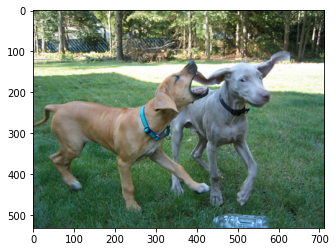

Beam: white dog and brown dog are wrestling in the grass


In [105]:
img = Image.open("/gdrive/My Drive/Automatic-Image-Captioning-master/sample_data/Screenshot (137).jpg")
newImg = img.resize((299,299), Image.BILINEAR).convert("RGB")
data = np.array( newImg.getdata() )
input=( data.reshape( (1, newImg.size[0], newImg.size[1], 3) ).astype( np.float32 )/255 ) - 1
image= model_new.predict(input) # Get the encoding vector for the image
x=plt.imread("/gdrive/My Drive/Automatic-Image-Captioning-master/sample_data/Screenshot (137).jpg")
plt.imshow(x)
plt.show()
print("Beam:",beam_search_pred(image))

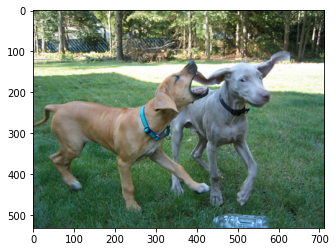

Greedy: two dogs are wrestling in the grass


In [106]:
img = Image.open("/gdrive/My Drive/Automatic-Image-Captioning-master/sample_data/Screenshot (137).jpg")
newImg = img.resize((299,299), Image.BILINEAR).convert("RGB")
data = np.array( newImg.getdata() )
input=( data.reshape( (1, newImg.size[0], newImg.size[1], 3) ).astype( np.float32 )/255 ) - 1
image= model_new.predict(input) # Get the encoding vector for the image
x=plt.imread("/gdrive/My Drive/Automatic-Image-Captioning-master/sample_data/Screenshot (137).jpg")
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))